# Data engineering

In [1]:
from pandas_profiling import ProfileReport
from dateutil.parser import parse

import multiprocessing as mp
import missingno as msno
import pandas as pd
import unicodedata
import numpy as np
import hashlib
import glob
import re

## Variables

In [2]:
RAW_DATA = './downloads/raw'
PPD_DATA = './downloads/pre-processed'

## Functions

Displays the profiling of the dataframe and saves it in a path

- df: dataframe to be analyzed
- title: title to be awarded in profiling
- f_out: path to the output file

In [3]:
def show_profiling(
    df: pd.DataFrame, title: str = None, f_out: str = None, **kwargs
) -> None:
    prof = ProfileReport(df, title=title, **kwargs)
    prof.to_widgets()
    if f_out:
        prof.to_file(output_file=f_out)

Converts all characters to ascii standard

- tokens: character list

return: list of converted characters

In [4]:
def _all2ascii(tokens: [str]) -> [str]:
    def _removes(token):
        token = unicodedata.normalize('NFKD', token)
        return token.encode('ascii', 'ignore').decode('utf-8', 'ignore')

    return [_removes(t) for t in tokens]

Converts all characters to lowercase

- tokens: character list

return: list of converted characters

In [5]:
def _all2lower(tokens: [str]) -> [str]:
    return [t.lower() for t in tokens]

Removes all punctuation from the character list

- tokens: character list

return: character list with punctuation removed

In [6]:
def _changes_punctuation(tokens: [str]) -> [str]:
    return [re.sub(r'[^\w\s]', '', t) for t in tokens]

Calculating the MD5 sum of a string

- text: text for calculating the MD5 sum

return: MD5 sum of a string

In [7]:
def _md5(text: str) -> str:
    return hashlib.md5(text.encode('utf-8')).hexdigest()

Normalize the string

- text: text to normalize
    
return: text normalized

In [8]:
def normalize(text: str) -> str:
    if not isinstance(text, str):
        return text

    tokens = text.split()
    tokens = _all2ascii(tokens)
    tokens = _all2lower(tokens)
    tokens = _changes_punctuation(tokens)
    return ' '.join(tokens)

Anonymize the string

- text: text to anonymize

return: MD5 sum of a string

In [9]:
def anonymize(text: str) -> str:
    if not isinstance(text, str):
        return text

    text = normalize(text)
    return _md5(text)

Base cleaning function

- df: input dataframe
- rules: substitution rules `{index: {'cols': columns, 'replaces': {value: new_value}, 'regex': bool}}` eg:
    - `{0: {'cols': 'Gender', 'replaces': {None:0.0}, 'regex': True}}`

In [10]:
def clean(df: pd.DataFrame, rules: {}) -> pd.DataFrame:    
    for rule in rules.values():
        cols = rule['cols']
        df[cols] = df[cols].replace(rule['replaces'], regex=rule['regex'])
    return df

Split string with multiple values

- register: string
- delimiter: delimiter to split
    
return: list

In [11]:
def split_mult(register: str, delimiter: str = ';'):
    if isinstance(register, str):
        return list(filter(None, register.split(delimiter)))
    else:
        return register

Function to decompose column

- row: dataframe row (Series)
    
return: comorbidities list (Series)

In [12]:
def decompose(row: pd.Series, col: str) -> pd.Series:
    if isinstance(row[col], list):
        for val in row[col]:
            if val.lower() == 'outros':
                val = f'[outros] {col}'
            row[val] = 1
    return row

Function to date parse

- val: possible date
    
return: date or NaN

In [13]:
def date_parse(val: str) -> str:
    try:
        return parse(val)
    except:
        return np.nan    

## Preprocessing

List xlsx files

In [14]:
files = glob.glob(f'{RAW_DATA}/*.xlsx')
files

['./downloads/raw/05_10_2020_Amostras_SESI_COVID-19_DN.xlsx',
 './downloads/raw/BOLETIM ENSAIOS PCR_01.07.2020_CORTE.xlsx',
 './downloads/raw/BOLETIM ENSAIOS PCR_CORTE 20_08_2020.xlsx']

In [15]:
FILE_NAME = '01_07-05_10'

xlsx2csv

In [16]:
df = pd.DataFrame()

for f in files:
    aux = pd.read_excel(f)
    df = pd.concat([df,aux], ignore_index=True)

df = df.rename(columns={c:re.sub(u'\xa0|\s$', '', c) for c in df.columns})
df.to_csv(f'{RAW_DATA}/{FILE_NAME}.csv', index=False)

### Clean dataset

load dataframe

In [17]:
df = pd.read_csv(f'{RAW_DATA}/{FILE_NAME}.csv', low_memory=False)

parse dates

In [18]:
parse_dates = [
    'Data de nascimento',
    'Data dos primeiros sintomas:',
    'Data da internação hospitalar:',
    'Data da alta hospitalar:',
    'Data do isolamento:',
    'Data da viagem de ida para outro local transmissão:',
    'Data da viagem de volta do outro local transmissão:',
    'DATA DA COLETA'
]
for col in parse_dates:
    df[col] = df[col].map(date_parse)

anonymization

In [19]:
col = 'Nome do paciente (completo)'
df[col] = df[col].map(anonymize)
df.drop('Número', axis=1, inplace=True)

normalize

In [20]:
cols = [
    'CEP',
    'Raça',
    'Sexo',
    'RESULTADO',
    'Apresenta sintomas?',
    'Paciente foi hospitalizado?',
    'Paciente foi submetido a ventilação mecânica?',
    'Situação de saúde do paciente no momento da notificação:*',
    'Foi realizada coleta de amostra do paciente?',
    'Paciente tem histórico de viagem para fora do Brasil até 14 dias antes do início dos sintomas?',
    'Foi para Wuhan, na China?',
    'Foi para outro local de transmissão?',
    'O paciente teve contato próximo com uma pessoa que seja caso suspeito, provável ou confirmado de COVID-19:*',
    'Esteve em alguma unidade de saúde nos 14 dias antes do início dos sintomas?*',
    'Ocupação', #
    'Se outra ocupação especificar', #
]
for col in cols:
    df[col] = df[col].map(normalize)

decompose column with multiple values

In [21]:
cols = [
    'Condições:Selecionar todas morbidades pertinentes.',
    'Selecione os sinais clínicos observados:',
    'Selecione os sintomas apresentados:',
]
for col in cols:
    df[col] = df[col].map(split_mult)

    pool = mp.Pool(mp.cpu_count())
    args = [(row,col) for _,row in df.iterrows()]
    results = pool.starmap_async(decompose, args).get()
    pool.close()
    pool.join()

    df = pd.DataFrame(results)

removes noise cols

In [22]:
noise_cols = [
    'Condições:Selecionar todas morbidades pertinentes.',
    'Selecione os sinais clínicos observados:',
    'Selecione os sintomas apresentados:',
    'Outros (se outros, especificar:)', # Sintomas
    '2020-06-25 00:00:00', # Sintomas
    ('Declaro que todas as informações são verdadeiras, recebi as orientações'
     ' sobre o procedimento do teste COVID-19 ( RT PCR) e  autorizo a'
     ' disponibilização do resultado do teste para o médico ou profi...'),
]
df.drop(noise_cols, axis=1, inplace=True)

Dictionary

|Sexo|Raça|Apresenta Sintomas?|Paciente foi hospitalizado?|Paciente foi submetido a ventilação mecânica?|Situação de saúde do paciente no momento da notificação:\*|Foi realizada coleta de amostra do paciente?|Paciente tem histórico de viagem para fora do Brasil até 14 dias antes do início dos sintomas?|Foi para Wuhan, na China?|Foi para outro local de transmissão?|O paciente teve contato próximo com uma pessoa que seja caso suspeito, provável ou confirmado de COVID-19:\*|Esteve em alguma unidade de saúde nos 14 dias antes do início dos sintomas?\*|RESULTADO
|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1: masculino|1: amarela|1: sim|1: sim|1: sim|1: sintomático|1: sim|1: sim|1: sim|1: sim|1: sim|1: sim|1: positivo|
|2: feminino|2: branca|2: não|2: não|2: não|2: assintomático|2: não|2: não|2: não|2: não|2: não|2: não|2: negativo|
||3: indigena||||3: cura|||||9: desconhecido||3: inconclusivo|
||4: parda||||9: ignorado||||||||
||5: preta||||||||||||

apply replaces rules and removes NaNs

In [23]:
rules_default = {
    'replaces': {r'^sim$': 1, r'^nao$': 2, r'\D': np.nan},
    'regex': True
}
rules = {
    0: {
        'cols': 'Sexo',
        'replaces': {'masculino': 1, 'feminino': 2, '4280000': np.nan},
        'regex': False
    },
    1: {
        'cols': 'Raça',
        'replaces': {
            'amarela': 1,
            'branca': 2,
            'indigena': 3,
            'parda': 4,
            'preta': 5,
            'pardal': np.nan,
        },
        'regex': False
    },
    2: {
        'cols': [
            'Apresenta sintomas?',
            'Paciente foi hospitalizado?',
            'Paciente foi submetido a ventilação mecânica?',
            'Foi realizada coleta de amostra do paciente?',
            'Paciente tem histórico de viagem para fora do Brasil até 14 dias antes do início dos sintomas?',
            'Foi para Wuhan, na China?',
            'Foi para outro local de transmissão?',
        ],
        **rules_default
    },
    3: {
        'cols': 'Situação de saúde do paciente no momento da notificação:*',
        'replaces': {
            'nao': np.nan,
            'sintomatico': 1,
            'assintomatico': 2,
            'cura': 3,
            'ignorado': 9,
        },
        'regex': False
    },
    4: {
        'cols': 'O paciente teve contato próximo com uma pessoa que seja caso suspeito, provável ou confirmado de COVID-19:*',
        'replaces': {
            'outro': np.nan,
            'domicilio': 1,
            'local de trabalho': 1,
            'unidade de saude': 1,
            'sim': 1,
            'nao': 2,
            'desconhecido': 9,
            'nao sabe': 9,
        },
        'regex': False
    },
    5: {
        'cols': 'Esteve em alguma unidade de saúde nos 14 dias antes do início dos sintomas?*',
        'replaces': {
            r'clinica.*': 1,
            r'hospital.*': 1,
            r'^sim$': 1,
            r'^nao$': 2,
            r'\D': np.nan,
        },
        'regex': True
    },
    6: {
        'cols': 'Se outra ocupação especificar',
        'replaces': {r'\d\s*': ''},
        'regex': True
    },
    7: {
        'cols': 'Se outra ocupação especificar',
        'replaces': {'': np.nan},
        'regex': False
    },
    8: {
        'cols': 'RESULTADO',
        'replaces': {'p': 1, 'n': 2, 'repetir': 9, 'inconclusivo': 9},
        'regex': False
    },
    9: {
        'cols': ['CEP', 'Idade em anos'],
        'replaces': {r'\D': np.nan},
        'regex': True
    }
}

In [24]:
df = clean(df, rules)
df = df[~df.isnull().all(axis=1)]

save

In [25]:
df.to_csv(f'{PPD_DATA}/{FILE_NAME}.csv', index=False)

Columns

In [26]:
[(i,c) for i,c in enumerate(df.columns)]

[(0, 'ID'),
 (1, 'Nome da Empresa'),
 (2, 'Data de nascimento'),
 (3, 'Idade em anos'),
 (4, 'Sexo'),
 (5, 'Raça'),
 (6, 'CEP'),
 (7, 'Rua'),
 (8, 'Complemento ( Condomínio, edifício, apto)'),
 (9, 'Bairro'),
 (10, 'Município'),
 (11, 'Estado'),
 (12, 'Apresenta sintomas?'),
 (13, 'Data dos primeiros sintomas:'),
 (14, 'Se outros sintomas apresentados, especificar:'),
 (15, 'Paciente foi hospitalizado?'),
 (16, 'Nome do hospital de internação:'),
 (17, 'Data da internação hospitalar:'),
 (18, 'Data da alta hospitalar:'),
 (19, 'Data do isolamento:'),
 (20, 'Paciente foi submetido a ventilação mecânica?'),
 (21, 'Situação de saúde do paciente no momento da notificação:*'),
 (22, 'Foi realizada coleta de amostra do paciente?'),
 (23,
  'Paciente tem histórico de viagem para fora do Brasil até 14 dias antes do início dos sintomas?'),
 (24, 'Foi para Wuhan, na China?'),
 (25, 'Foi para outro local de transmissão?'),
 (26, 'Outro local de transmissão (País, Estado ou cidade):'),
 (27, 'Data

Missing values (Questions)

<AxesSubplot:>

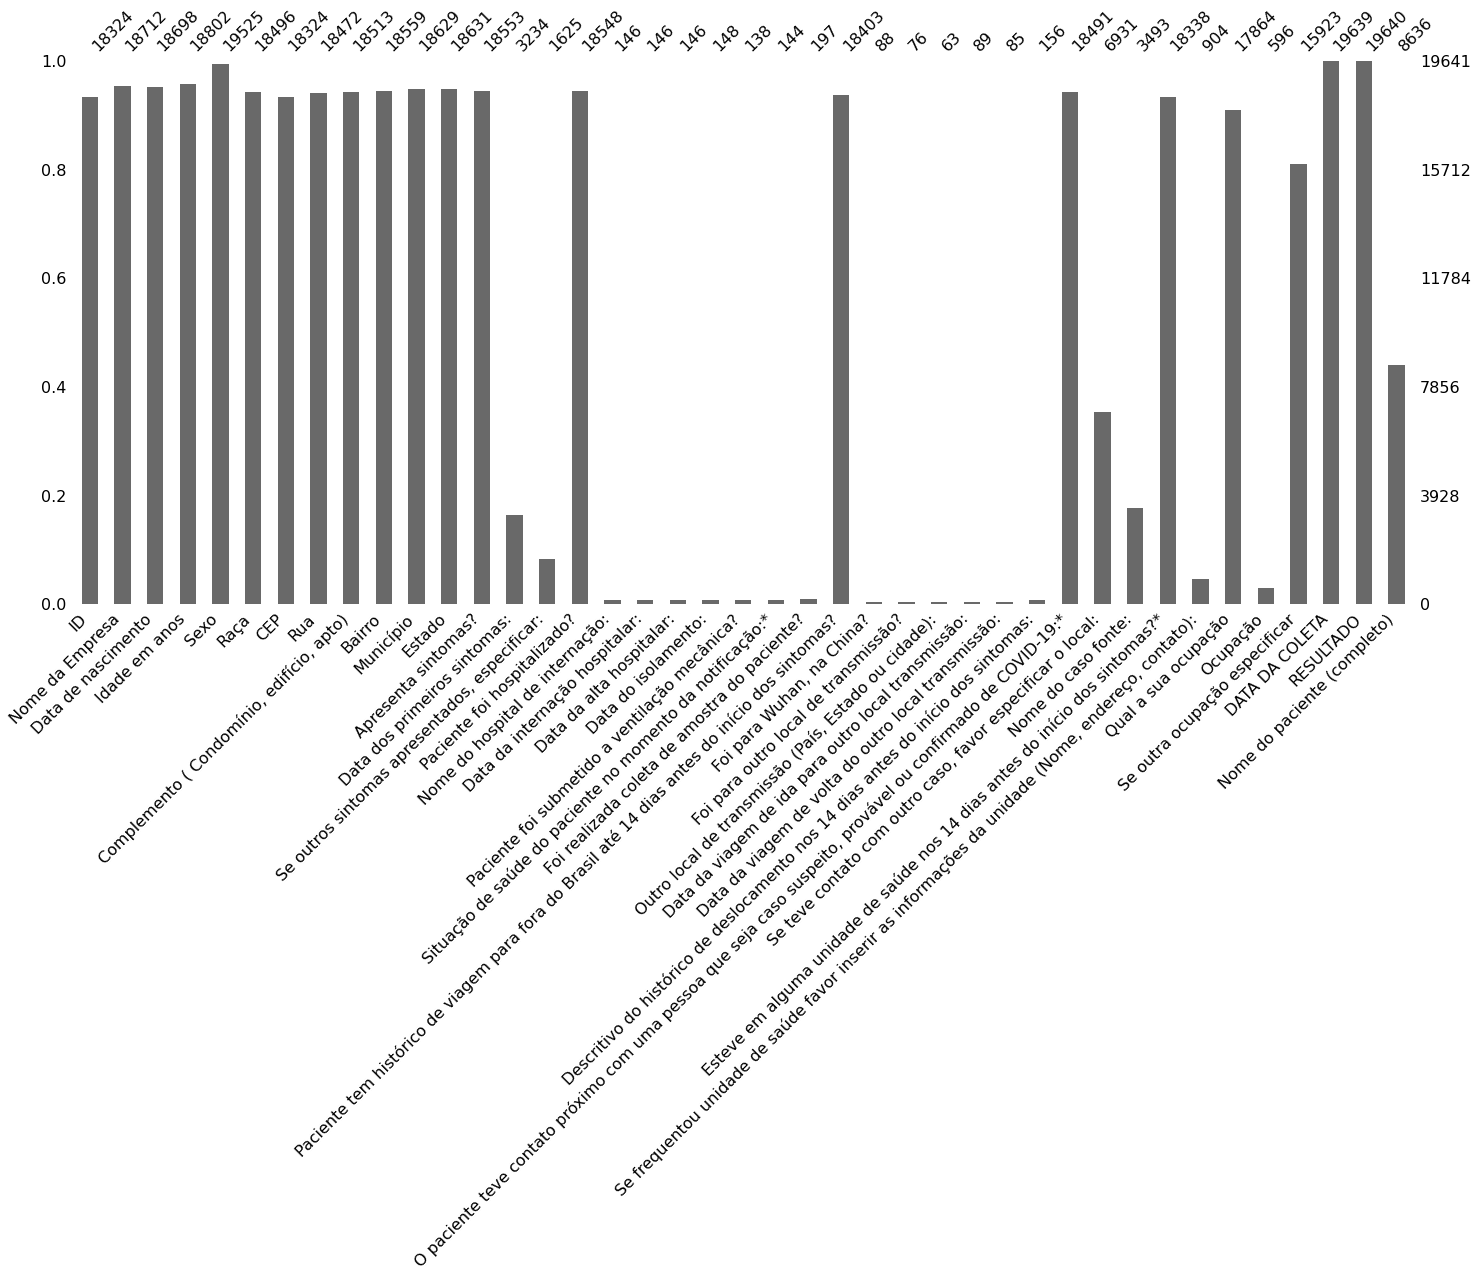

In [27]:
msno.bar(df[df.columns[:41]])

Missing values (Decomposed columns)

<AxesSubplot:>

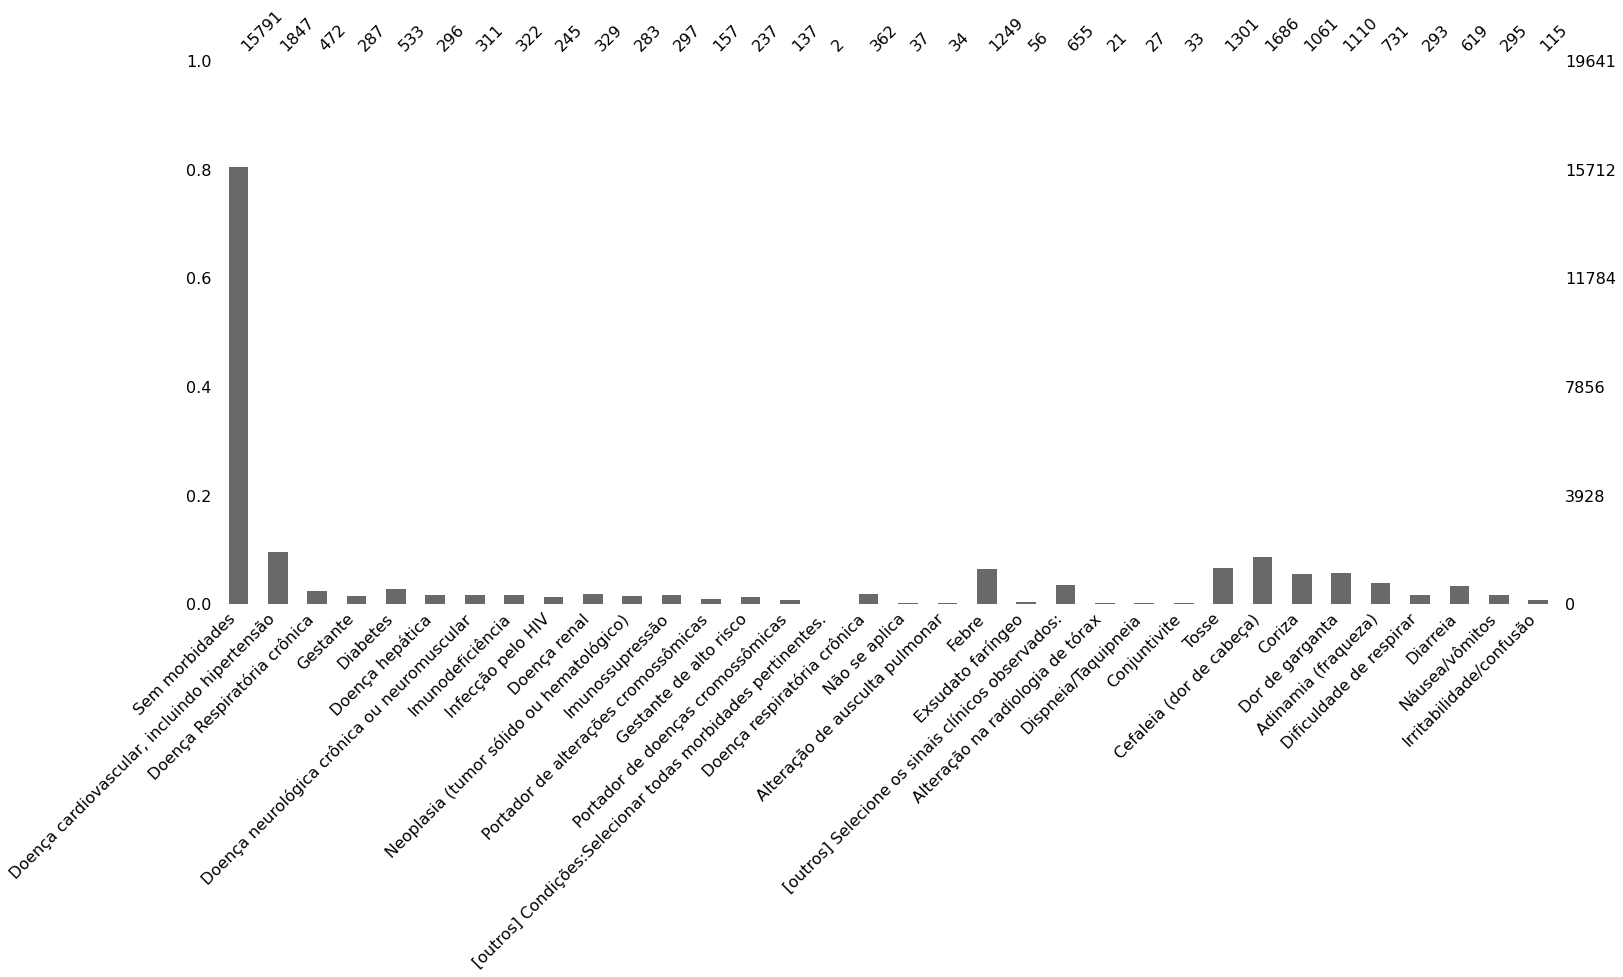

In [28]:
msno.bar(df[df.columns[41:]])

Profiling

In [29]:
show_profiling(
    df,
    title='PCR Analysis',
    f_out=f'{PPD_DATA}/{FILE_NAME}.csv.html',
    correlations={"cramers": {"calculate": False}}
)

In [30]:
df = pd.read_csv(f'{PPD_DATA}/{FILE_NAME}.csv', low_memory=False)

Creating dataframe with addresses

In [31]:
df_chunk = pd.read_csv(f'{PPD_DATA}/{FILE_NAME}.csv', low_memory=False, chunksize=300)

for idx,chunk in enumerate(df_chunk):
    addr = chunk.loc[:,:]
    addr.loc[:,'CEP'] = addr.loc[:,'CEP'].map(lambda x: str(int(x)) if not np.isnan(x) else '')
    addr['addr'] = (
        addr.loc[:,'Rua']
        + ', ' + addr.loc[:,'Complemento ( Condomínio, edifício, apto)']
        + ', ' + addr.loc[:,'Bairro']
        + ', ' + addr.loc[:,'Município']
        + ', ' + addr.loc[:,'Estado']
        + ', CEP: ' + addr.loc[:,'CEP']
    )
    addr.to_csv(f'{PPD_DATA}/pregeo/ADDRESS_{idx:02d}.csv', index=False)

Concatenating processor addresses by [pyaddress](https://github.com/patricksferraz/pyaddress) on the dataframe

In [32]:
df = pd.read_csv(f'{PPD_DATA}/{FILE_NAME}-geo.csv', low_memory=False)

def geocode(r) -> set:
    try:
        data = eval(r['results'])[0]
        coord = data['geometry']['location']
        r['lat'] = coord['lat']
        r['lon'] = coord['lng']
    except:
        pass
    finally:
        return r

df = df.apply(geocode, axis=1)
df.to_csv(f'{PPD_DATA}/{FILE_NAME}-wcoords.csv', index=False)